In [1]:
! pip install xgboost

import xgboost as xgb
from xgboost import XGBClassifier, Booster, DMatrix

from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import boto3
import sagemaker
import pandas as pd
import numpy as np
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt

import yaml
import os
import sys
# import s3fs
# import pyarrow.parquet as pq
# s3 = s3fs.S3FileSystem
! pip install awswrangler
import awswrangler as wr
sys.path.extend(['../src/preprocess', '../config'])
import helpers.instance as ins
import helpers.s3 as s3_helper
import helpers.utils as ut
import helpers.athena as at


[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: pip install --upgrade pip


In [2]:
from sklearn.utils import resample
train = pd.read_csv('trained_data')
df_min = train[train.flag_cameback ==1]
df_max = train[train.flag_cameback ==0]
df_max_downsampled = resample(df_max, 
                             replace=False,
                             n_samples = 6000,
                             random_state = 123)

In [3]:
train = pd.concat([df_min, df_max_downsampled])
train

,Unnamed: 0,unit_num,Tot_cost_24,Tot_cost_12,Tot_cost_6,Tot_cost_3,AvgT_cost_24,AvgT_cost_12,AvgT_cost_6,AvgT_cost_3,...,UNIT_SIZE,PRODUCT_LINE,UNIT_MAKE_CODE,UNIT_MODEL_YEAR,UNIT_FUEL_TYPE,UNIT_BODY_TYPE,UNIT_SOLD_DATE,unit_sold_date,flag_cameback,unit_sold_flag
2,5,100027,0.00,0.00,0.00,0.0,0.0000,0.0000,0.0000,0.0,...,HEAVY,LEASE,FTL,2015,DIESEL,4002 13,2020-10-05,2020-10-05 00:00:00.000,1.0,1
5,10,100044,0.00,0.00,0.00,0.0,0.0000,0.0000,0.0000,0.0,...,HEAVY,LEASE,FTL,2015,DIESEL,4002 13,2020-08-19,2020-08-19 00:00:00.000,1.0,1
6,16,100054,0.00,0.00,0.00,0.0,0.0000,0.0000,0.0000,0.0,...,HEAVY,COMMERCIAL RENTAL,FTL,2015,DIESEL,4002 13,2019-05-24,2019-05-24 00:00:00.000,1.0,1
9,26,100077,0.00,0.00,0.00,0.0,0.0000,0.0000,0.0000,0.0,...,HEAVY,LEASE,FTL,2015,DIESEL,4002 13,2020-01-09,2020-01-09 00:00:00.000,1.0,1
12,34,100099,3875.01,3875.01,3875.01,0.0,968.7525,968.7525,968.7525,0.0,...,HEAVY,COMMERCIAL RENTAL,FTL,2015,DIESEL,4002 13,2020-10-02,2020-10-02 00:00:00.000,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32883,57740,CNG223,0.00,0.00,0.00,0.0,0.0000,0.0000,0.0000,0.0,...,HEAVY,LEASE,FTL,2015,OTHER,4002 13,2020-04-02,NaN,0.0,1
29164,50206,9172601,0.00,0.00,0.00,0.0,0.0000,0.0000,0.0000,0.0,...,LIGHT,CONSUMER RENTAL,FOR,2016,GAS,6015 02,2019-09-04,NaN,0.0,1
25170,42074,8505549,0.00,0.00,0.00,0.0,0.0000,0.0000,0.0000,0.0,...,HEAVY,CONTRACT MAINTENANCE - PEG,FTL,2005,DIESEL,4002 13,2019-12-01,NaN,0.0,1
23971,39997,8209122,0.00,0.00,0.00,0.0,0.0000,0.0000,0.0000,0.0,...,NaN,CONTRACT MAINTENANCE - PEG,GDT,2013,NONE,5299 22,2020-02-19,NaN,0.0,1


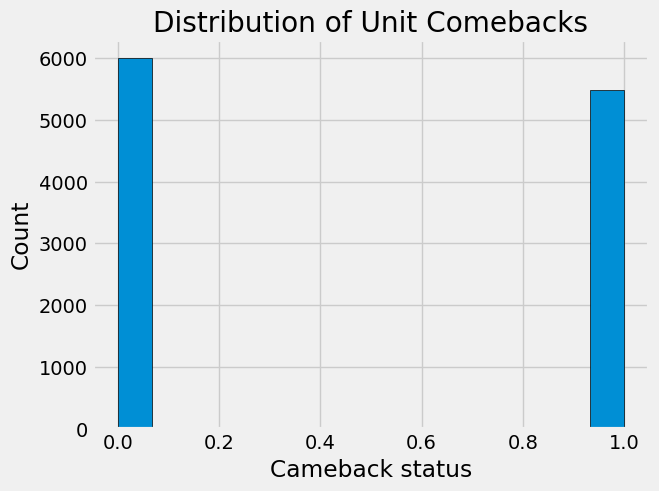

In [4]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.hist(train['flag_cameback'], bins=15, edgecolor='black')
plt.title('Distribution of Unit Comebacks')
plt.xlabel('Cameback status')
plt.ylabel('Count')
plt.show()

In [5]:
train['unit_num'] = train['unit_num'].astype('str')

In [6]:
train['UNIT_SOLD_DATE'] = pd.to_datetime(train['UNIT_SOLD_DATE'], format='%Y-%m-%d')
train['Month'] = train['UNIT_SOLD_DATE'].dt.month
train['Sin_Month'] = np.sin(2 * np.pi * train['Month']/ max(train['Month']))
train['Cos_Month'] = np.cos(2 * np.pi * train['Month']/ max(train['Month']))
train['Day'] = train['UNIT_SOLD_DATE'].dt.day
train['Sin_Day'] = np.sin(2 * np.pi * train['Day']/ max(train['Day']))
train['Cos_Day'] = np.cos(2 * np.pi * train['Day']/ max(train['Day']))

In [7]:
train = train.drop(columns = 'UNIT_SOLD_DATE')
train = train.drop(columns = 'unit_sold_date')

In [8]:
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
cols = ['LOCATION', 'AREA', 'REGION', 'DISTRICT', 'UNIT_CATEGORY', 'UNIT_SIZE', 'PRODUCT_LINE', 'UNIT_MAKE_CODE', 'UNIT_MODEL_YEAR', 
        'UNIT_FUEL_TYPE', 'UNIT_BODY_TYPE']
#, 'unit_sold_date'
#from sklearn import LabelBinarizer
encode_columns = train[cols].astype('str')
encode_columns = encode_columns.apply(lbl.fit_transform)
drop_test = train.drop(cols,axis=1)
final_dset = pd.concat([drop_test, encode_columns], axis=1) 

In [9]:
pd.set_option('display.max_columns', None)

In [10]:
train['unit_num']

2           100027
5           100044
6           100054
9           100077
12          100099
           ...    
32883       CNG223
29164      9172601
25170      8505549
23971      8209122
37933    PECO43502
Name: unit_num, Length: 11480, dtype: object

In [11]:
X = final_dset.drop(columns = ['flag_cameback', 'unit_num'])
y = final_dset['flag_cameback']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 1337)

In [13]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8036, 59)
(3444, 59)
(8036,)
(3444,)


In [14]:
print(X.columns)

Index(['Unnamed: 0', 'Tot_cost_24', 'Tot_cost_12', 'Tot_cost_6', 'Tot_cost_3',
       'AvgT_cost_24', 'AvgT_cost_12', 'AvgT_cost_6', 'AvgT_cost_3',
       'Outside_cost_12', 'total_time_call_12', 'total_call_12',
       'total_po_sum_12', 'time_customer_billed_12', 'LTD_Total_cost',
       'LTD_Labour_cost', 'LTD_Outside_cost', 'LTD_Parts_cost',
       'LTD_Big_repair', 'LTD_Major_PM', 'LTD_Road_calls', 'LTD_Handle_time',
       'LTD_TOTAL_REPAIRS', 'LTD_customer_rebilled', 'LTD_PO_Amount',
       'LTD_Labour_hours', 'LTD_Accients_incidents', 'avg_pm_ontime_percent',
       'avg_critical_oil_sample_percent', 'diff_prev6', 'diff_prev12',
       'diff_prev3', 'milesdiff_1_6', 'costPermile_1diff6',
       'Repairs_diff_prev6', 'Curr_miles', 'cur_vintage', 'MajorPM_24_sum',
       'dloc_nt', 'dregion_cnt', 'darea_cnt', 'unit_sold_flag', 'Month',
       'Sin_Month', 'Cos_Month', 'Day', 'Sin_Day', 'Cos_Day', 'LOCATION',
       'AREA', 'REGION', 'DISTRICT', 'UNIT_CATEGORY', 'UNIT_SIZE',
     

In [15]:
print(y)

2        1.0
5        1.0
6        1.0
9        1.0
12       1.0
        ... 
32883    0.0
29164    0.0
25170    0.0
23971    0.0
37933    0.0
Name: flag_cameback, Length: 11480, dtype: float64


In [16]:
model = XGBClassifier(tree_method = 'hist', colsample_bytree = 0.7, max_depth = 3, n_estimator = 60, min_child_weight = 6, enable_categorical = True,
                      learning_rate = 0.1, subsample = 0.9)

In [17]:
model.fit(X_train, y_train)

[14:19:43] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=6,
              missing=nan, monotone_constraints='()', n_estimator=60,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', predictor='auto', random_state=0, ...)

In [18]:
import pickle
with open('xgbmodel.pk1', 'wb') as file:
    pickle.dump(model, file)
model_pickle = pickle.dumps(model)

In [19]:
dataset_cfg = ins.read_config('../config/datasets.yaml') 
config_cfg = ins.read_config('../config/config.yaml')
prefix = dataset_cfg['prefix']
bucket = dataset_cfg['bucket']
bucket = boto3.Session().resource('s3').Bucket(bucket)
bucket.Object(os.path.join(prefix, 'Data/Processed/initial_XGBmodel.pk1')).put(Body = model_pickle)

{'ResponseMetadata': {'RequestId': '5B1G905BRBDCC2BE',
  'HostId': 'urtWRsJOhnhFQWaBluu4I0SA5G/JBlJWqbzhikbJdHVfVfsn6WS1APUy7hGeD2YtJsAODZj3uLw=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'urtWRsJOhnhFQWaBluu4I0SA5G/JBlJWqbzhikbJdHVfVfsn6WS1APUy7hGeD2YtJsAODZj3uLw=',
   'x-amz-request-id': '5B1G905BRBDCC2BE',
   'date': 'Thu, 28 Jul 2022 14:19:45 GMT',
   'etag': '"8e5a53b6be7df7882a265c5ea055f3b0"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"8e5a53b6be7df7882a265c5ea055f3b0"'}

In [20]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 0, ..., 1, 1, 0])

In [21]:
model.feature_importances_

array([0.12198228, 0.        , 0.        , 0.01086961, 0.00880765,
       0.00806765, 0.01405886, 0.01114752, 0.0084204 , 0.00885758,
       0.        , 0.        , 0.        , 0.        , 0.00845321,
       0.01388383, 0.00813877, 0.01252479, 0.00765773, 0.        ,
       0.        , 0.01142213, 0.01561659, 0.00510828, 0.00818032,
       0.01179919, 0.00895546, 0.01685396, 0.03738184, 0.00847745,
       0.01168896, 0.01479019, 0.00899738, 0.00767976, 0.00908392,
       0.07061791, 0.02668208, 0.0080312 , 0.01142453, 0.        ,
       0.        , 0.        , 0.01093389, 0.01990815, 0.01366105,
       0.01934322, 0.0100357 , 0.01658828, 0.00988914, 0.01221   ,
       0.03450052, 0.01048035, 0.01500844, 0.02963821, 0.09739602,
       0.01048878, 0.05638067, 0.06204107, 0.03583547], dtype=float32)

In [22]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy*100.0))

Accuracy: 71.05%


In [23]:
kfold = KFold(n_splits=10, random_state = 7)
results = cross_val_score(model, y_test, y_pred, cv=kfold)
results

[14:19:44] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


[14:19:45] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:19:45] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:19:46] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
 

array([0.75362319, 0.72173913, 0.70144928, 0.73623188, 0.69767442,
       0.7122093 , 0.66860465, 0.72965116, 0.71511628, 0.66860465])

In [24]:
print("Accuracy: %.2f%%" % (results.mean()*100.0))

Accuracy: 71.05%


In [ ]:
def xgboost_search(X, y, search_verbose =1):
    params = {
        "max_depth": [3,4,5,6,7],
        "min_child_weight": [3,4,5,6,7],
        "subsample": [0.6, 0.7, 0.8, 0.9],
        "colsample_bytree": [0.6, 0.7, 0.8, 0.9],
        "learning_rate": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
    }
    xgb = XGBClassifier(objectives = "binary:logistic", eval_metric= "")

In [25]:
prefix = dataset_cfg['prefix']
bucket = dataset_cfg['bucket']
bucket = boto3.Session().resource('s3').Bucket(bucket)
bucket.Object(os.path.join(prefix, 'Data/Processed/intial_xgb_model.pk1')).put(Body=results)

ParamValidationError: Parameter validation failed:
Invalid type for parameter Body, value: [0.75362319 0.72173913 0.70144928 0.73623188 0.69767442 0.7122093
 0.66860465 0.72965116 0.71511628 0.66860465], type: <class 'numpy.ndarray'>, valid types: <class 'bytes'>, <class 'bytearray'>, file-like object

In [ ]:
#separate notebook
3 = boto3.resource('s3')
use_model = pickle.loads(s3.Bucket('pske-stg-advanalytics').Object('Projects/Unit_Sale_Risk_Interns/Data/Processed/initial_XGBmodel.pk1'))